In [1]:
# Imports and initialization

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [2]:
# Problem constants

r_0 = 0.5
beta = np.array([1.0, 10.0])
alpha = 1.0

In [3]:
# Shallow neural networks for PINN

class PINN(nn.Module):

    def __init__(self, in_dim, h_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=h_dim),
            nn.Tanh(),
            nn.Linear(in_features=h_dim, out_features=out_dim, bias=False)
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [4]:
# Loss functions for residual PDE

# u: control
# v: state
# p: adjoint


# State PDE residual loss

def loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, \
                   grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner):
    p_inner_pred = model_p(X_inner)
    u_inner_pred = -(1.0 / alpha) * h_inner * p_inner_pred
    v_inner_pred = model_v(X_inner)
    dvdX = torch.autograd.grad(
        v_inner_pred, X_inner,
        grad_outputs=torch.ones_like(v_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # v_x v_y v_z
    dvdX_xX = torch.autograd.grad(
        dvdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # v_xx v_xy v_xz
    dvdX_yX = torch.autograd.grad(
        dvdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # v_yx v_yy v_yz
    dvdX_zX = torch.autograd.grad(
        dvdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,2]),
        create_graph=True
        )[0] # v_zx v_zy v_zz

    v_xx = dvdX_xX[:,0].reshape(len(dvdX_xX[:,0]), 1)
    v_yy = dvdX_yX[:,1].reshape(len(dvdX_yX[:,1]), 1)
    v_zz = dvdX_zX[:,2].reshape(len(dvdX_zX[:,2]), 1)
    v_xz = dvdX_xX[:,2].reshape(len(dvdX_xX[:,2]), 1)
    v_yz = dvdX_yX[:,2].reshape(len(dvdX_yX[:,2]), 1)
    v_z = dvdX[:,2].reshape(len(dvdX[:,2]), 1)
    v_x = dvdX[:,0].reshape(len(dvdX[:,0]), 1)
    v_y = dvdX[:,1].reshape(len(dvdX[:,1]), 1)

    tilde_v_x = v_x + v_z * grad_z_inner[:,0:1]
    tilde_v_y = v_y + v_z * grad_z_inner[:,1:2]
    tilde_v_xx = v_xx + 2.0 * v_xz * grad_z_inner[:,0:1] + v_zz * (grad_z_inner[:,0:1]**2) + v_z * grad_grad_z_inner[:,0:1]
    tilde_v_yy = v_yy + 2.0 * v_yz * grad_z_inner[:,1:2] + v_zz * (grad_z_inner[:,1:2]**2) + v_z * grad_grad_z_inner[:,1:2]

    laplace = grad_grad_g_inner[:,0:1] + grad_grad_g_inner[:,1:2] \
        + v_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
            2.0 * tilde_v_x * grad_h_inner[:,0:1] + 2.0 * tilde_v_y * grad_h_inner[:,1:2] \
                + h_inner * (tilde_v_xx + tilde_v_yy)

    loss_res = torch.mean((laplace + (u_inner_pred + Rf_inner) / Beta_inner) ** 2)
    return loss_res



# State PDE interface jump loss

def loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, grad_z_ij, h_ij, grad_h_ij, grad_g_ij):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)

    v_ij_outer = model_v(ij_outer)

    vx_ij_outer = torch.autograd.grad(
        v_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(v_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]


    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = normal_x * (grad_g_ij[:,0:1] + vx_ij_outer[:,0:1] * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (grad_g_ij[:,1:2] + vx_ij_outer[:,1:2] * h_ij + v_ij_outer * grad_h_ij[:,1:2])

    tilde_vx_ij_inner_x = vx_ij_outer[:,0:1] + vx_ij_outer[:,2:3] * grad_z_ij[:,0:1]
    tilde_vx_ij_inner_y = vx_ij_outer[:,1:2] + vx_ij_outer[:,2:3] * grad_z_ij[:,1:2]
    Normal_inner = normal_x * (grad_g_ij[:,0:1] + tilde_vx_ij_inner_x * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (grad_g_ij[:,1:2] + tilde_vx_ij_inner_y * h_ij + v_ij_outer * grad_h_ij[:,1:2])

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Vnj_ij)**2)

    return loss_normal_jump


In [5]:
# Loss functions for adjoint PDEs

# Adjoint PDE residual loss

def loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner, \
                 grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, g_inner):

    v_inner_pred = model_v(X_inner)
    p_inner_pred = model_p(X_inner)
    dpdX = torch.autograd.grad(
        p_inner_pred, X_inner,
        grad_outputs=torch.ones_like(p_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # p_x p_y
    dpdX_xX = torch.autograd.grad(
        dpdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # p_xx p_xy p_xz
    dpdX_yX = torch.autograd.grad(
        dpdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # p_yx p_yy p_yz
    dpdX_zX = torch.autograd.grad(
        dpdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,2]),
        retain_graph=True,
        create_graph=True
        )[0] # p_zx p_zy p_zz

    p_xx = dpdX_xX[:,0].reshape(len(dpdX_xX[:,0]), 1)
    p_yy = dpdX_yX[:,1].reshape(len(dpdX_yX[:,1]), 1)
    p_zz = dpdX_zX[:,2].reshape(len(dpdX_zX[:,2]), 1)
    p_xz = dpdX_xX[:,2].reshape(len(dpdX_xX[:,2]), 1)
    p_yz = dpdX_yX[:,2].reshape(len(dpdX_yX[:,2]), 1)
    p_z = dpdX[:,2].reshape(len(dpdX[:,2]), 1)
    p_x = dpdX[:,0].reshape(len(dpdX[:,0]), 1)
    p_y = dpdX[:,1].reshape(len(dpdX[:,1]), 1)

    tilde_p_x = p_x + p_z * grad_z_inner[:,0:1]
    tilde_p_y = p_y + p_z * grad_z_inner[:,1:2]
    tilde_p_xx = p_xx + 2.0 * p_xz * grad_z_inner[:,0:1] + p_zz * (grad_z_inner[:,0:1]**2) + p_z * grad_grad_z_inner[:,0:1]
    tilde_p_yy = p_yy + 2.0 * p_yz * grad_z_inner[:,1:2] + p_zz * (grad_z_inner[:,1:2]**2) + p_z * grad_grad_z_inner[:,1:2]

    laplace = p_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
        2.0 * tilde_p_x * grad_h_inner[:,0:1] + 2.0 * tilde_p_y * grad_h_inner[:,1:2] \
            + h_inner * (tilde_p_xx + tilde_p_yy)

    loss_res = torch.mean((laplace + (g_inner + h_inner * v_inner_pred - vd_inner) / Beta_inner) ** 2)
    return loss_res



# Adjoint interface jump loss

def loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, grad_z_ij, h_ij, grad_h_ij):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)

    u_ij_outer = model_p(ij_outer)

    ux_ij_outer = torch.autograd.grad(
        u_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(u_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = normal_x * (ux_ij_outer[:,0:1] * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (ux_ij_outer[:,1:2] * h_ij + u_ij_outer * grad_h_ij[:,1:2])

    tilde_ux_ij_inner_x = ux_ij_outer[:,0:1] + ux_ij_outer[:,2:3] * grad_z_ij[:,0:1]
    tilde_ux_ij_inner_y = ux_ij_outer[:,1:2] + ux_ij_outer[:,2:3] * grad_z_ij[:,1:2]
    Normal_inner = normal_x * (tilde_ux_ij_inner_x * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (tilde_ux_ij_inner_y * h_ij + u_ij_outer * grad_h_ij[:,1:2])    # here u_ij_inner = u_ij_outer

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Pnj_ij)**2)

    return loss_normal_jump

In [6]:
# Total loss function

def loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, X_ij, Normal_ij, Vnj_ij, Pnj_ij, 
         grad_z_inner, grad_grad_z_inner, grad_z_ij, g_inner, grad_grad_g_inner, grad_g_ij, 
         h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij):
    loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner,
                             grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner)
    loss_vij = loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, grad_z_ij, h_ij, grad_h_ij, grad_g_ij)
    loss_pr = loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner,
                           grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, g_inner)
    loss_pij = loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, grad_z_ij, h_ij, grad_h_ij)
    loss_total = 3.0 * loss_vr + loss_vij + loss_pr + loss_pij
    return loss_total, loss_vr, loss_vij, loss_pr, loss_pij


In [7]:
# Problem parameters

# Exact solutions
# Return state, control and adjoint in order

def exact_u(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    phi = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    u = -(1/alpha) * phi
    return u

def exact_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    v = np.power(x**2 + y**2, 1.5) / Beta  + (1.0 / beta[0] - 1.0 / beta[1]) * (r_0 ** 3) * (0.5 * (z + 1.0))
    return v

def exact_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    p = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    return p

# Normal vectors for points on interface
def normal_vector(x, y):
    dist = np.sqrt(x**2 + y**2)
    normal_x = x / dist
    normal_y = y / dist
    normal = np.hstack((normal_x, normal_y))
    return normal

# Normal derivative of state on the interface
def normal_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    temp = 3.0 * np.sqrt(x**2 + y**2) / Beta
    grad_x = temp * x
    grad_y = temp * y
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Normal derivative of adjoint on the interface
def normal_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    grad_x = (-5.0) * 2.0 * x * (y**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    grad_y = (-5.0) * 2.0 * y * (x**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Desired state function
def vd(x, y, z):
    v = exact_v(x, y, z)
    laplace_beta_p = (-5.0) * (2.0 * (x**4 + y**4 + 12.0 * (x**2) * (y**2)) - (16.0 + 2.0 * (r_0)**2) * (x**2 + y**2) + 4.0 * (r_0**2 + 1.0))
    return v + laplace_beta_p


# Right hand side of state-control PDE
def rhs_f(x, y, z):
    u = exact_u(x, y, z)
    return -9.0 * np.sqrt(x**2 + y**2) - u



In [8]:
# Auxiliary functions

# Determine which region does (x, y) belong to
def sign_x(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = -1.0
    return z

# Auxiliary function phi in paper
def z_val(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = 4.0 * (dist**2)
    return z

def grad_z_val(x, y):
    z = np.hstack([0.0 * x, 0.0 * x])
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i,0] = 8.0 * x[i]
            z[i,1] = 8.0 * y[i]
    return z

def grad_grad_z_val(x, y):
    z = np.hstack([0.0 * x, 0.0 * x])
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i,0] = 8.0
            z[i,1] = 8.0
    return z

def grad_z_ij_val(x, y):
    z = np.hstack([8.0 * x, 8.0 * y])
    return z

# Function h in paper
def h_val(x, y):
    return (x**2 - 1.0) * (y**2 - 1.0)

def grad_h_val(x, y):
    h_x = 2.0 * x * (y**2 - 1.0)
    h_y = 2.0 * y * (x**2 - 1.0)
    return np.hstack([h_x, h_y])

def grad_grad_h_val(x, y):
    h_xx = 2.0 * (y**2 - 1.0)
    h_yy = 2.0 * (x**2 - 1.0)
    return np.hstack([h_xx, h_yy])

# Function g in paper
def g_val(x, y):
    return np.power(x**2 * y**2 + 1.0, 1.5) / beta[1]  + (1.0 / beta[0] - 1.0 / beta[1]) * (r_0 ** 3)

def grad_g_val(x, y):
    h_x = (3.0 * np.sqrt(x**2 * y**2 + 1.0) * y**2 * x) / beta[1]
    h_y = (3.0 * np.sqrt(x**2 * y**2 + 1.0) * x**2 * y) / beta[1]
    return np.hstack([h_x, h_y])

def grad_grad_g_val(x, y):
    h_xx = (3.0 * (2.0 * x**2 * y**4 + y**2) / np.sqrt(x**2 * y**2 + 1.0)) / beta[1]
    h_yy = (3.0 * (2.0 * x**4 * y**2 + x**2) / np.sqrt(x**2 * y**2 + 1.0)) / beta[1]
    return np.hstack([h_xx, h_yy])

# Uniform sampling
def uniform_sampling(dim, n):
    return 2.0 * np.random.rand(n**dim, dim) - 1.0


In [9]:
# Initialize training data

# Density of grid points
N_inner = 32

# Sampling training points

# X_inner: points inside the domain, totally N_inner**2 points
# z: value of auxiliary function phi at a inner training point
# z_sign: the region where a trainin point belongs to
X_inner = uniform_sampling(2, N_inner)
x = X_inner[:, 0:1]
y = X_inner[:, 1:2]
z = z_val(x, y)
z_sign = sign_x(x, y)
grad_z_inner = grad_z_val(x, y)
grad_grad_z_inner = grad_grad_z_val(x, y)
Beta_inner = 0.5 * beta[0] * (1.0 - z_sign) + 0.5 * beta[1] * (1.0 + z_sign)
X_inner = np.hstack((X_inner, z))

# Problem parameters
vd_inner = vd(x, y, z_sign)
Rf_inner = rhs_f(x, y, z_sign)

# Value of auxiliary functions g, h on inner training points
h_inner = h_val(x, y)
grad_h_inner = grad_h_val(x, y)
grad_grad_h_inner = grad_grad_h_val(x, y)
g_inner = g_val(x, y)
grad_grad_g_inner = grad_grad_g_val(x, y)

# X_ij: points on the interior interface, totally 8*N_inner points
# z_ij: auxiliary function values on interface
theta = 2.0 * np.pi * np.random.rand(8 * N_inner, 1)
x_ij = 0.5 * np.cos(theta)
y_ij = 0.5 * np.sin(theta)
grad_z_ij = grad_z_ij_val(x_ij, y_ij)
X_ij = np.hstack([x_ij, y_ij])

# unit normal vector on interface
Normal_ij = normal_vector(x_ij, y_ij)

# Vnj_ij: state function normal jump on the interior interface
Vnj_ij = beta[1] * normal_v(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_v(x_ij, y_ij, 0.0 * x_ij - 1.0)

## Pnj_ij: adjoint function normal jump on the interior interface
Pnj_ij = beta[1] * normal_p(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_p(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Value of auxiliary functions g, h on interface
h_ij = h_val(x_ij, y_ij)
grad_h_ij = grad_h_val(x_ij, y_ij)
grad_g_ij = grad_g_val(x_ij, y_ij)


In [10]:
# Convert numpy arrays to tensors and pass to training device

X_inner = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
vd_inner = torch.from_numpy(vd_inner).double().to(device)
Rf_inner = torch.from_numpy(Rf_inner).double().to(device)
Beta_inner = torch.from_numpy(Beta_inner).double().to(device)

grad_z_inner = torch.from_numpy(grad_z_inner).double().to(device)
grad_grad_z_inner = torch.from_numpy(grad_grad_z_inner).double().to(device)
h_inner = torch.from_numpy(h_inner).double().to(device)
grad_h_inner = torch.from_numpy(grad_h_inner).double().to(device)
grad_grad_h_inner = torch.from_numpy(grad_grad_h_inner).double().to(device)
g_inner = torch.from_numpy(g_inner).double().to(device)
grad_grad_g_inner = torch.from_numpy(grad_grad_g_inner).double().to(device)

X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij = torch.from_numpy(Normal_ij).double().to(device)
Vnj_ij = torch.from_numpy(Vnj_ij).double().to(device)
Pnj_ij = torch.from_numpy(Pnj_ij).double().to(device)

grad_z_ij = torch.from_numpy(grad_z_ij).double().to(device)
h_ij = torch.from_numpy(h_ij).double().to(device)
grad_h_ij = torch.from_numpy(grad_h_ij).double().to(device)
grad_g_ij = torch.from_numpy(grad_g_ij).double().to(device)


In [11]:
# Model, optimizer and learning rates

# PINN model
model_v = PINN(3, 100, 1).to(device)
model_p = PINN(3, 100, 1).to(device)
print(model_v)
print(model_p)

# Optimizer
optimizer = torch.optim.Adam(
    list(model_v.parameters()) + list(model_p.parameters()),
    lr=0.001)
max_iter = 40000 # stop when iter > Adam_iter

# Step size scheduler
def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 5000
    update_lr_2 = 10000
    update_lr_3 = 20000
    update_lr_4 = 30000
    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 0.0002
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001
    if step == update_lr_4:
        for g in optimizer.param_groups:
            g['lr'] = 0.00003


PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)
PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)


In [12]:
# Training loop

model_v.train()
model_p.train()

loss_hist = []
pbar = trange(max_iter)

for step in pbar:

    lr_adjust(step, optimizer)

    # Backward and optimize
    optimizer.zero_grad()
    loss_total, loss_vr, loss_vij, loss_pr, loss_pij = \
            loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, \
                    X_ij, Normal_ij, Vnj_ij, Pnj_ij, \
                        grad_z_inner, grad_grad_z_inner, grad_z_ij, g_inner, grad_grad_g_inner, grad_g_ij, \
                            h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij)
    loss_total.backward()
    optimizer.step()

    if step % 100 == 0:
        pbar.set_postfix({'loss': '{0:.5e}'.format(loss_total.item()),
                          'loss_vr': '{0:.5e}'.format(loss_vr.item()),
                          'loss_vij': '{0:.5e}'.format(loss_vij.item()),
                          'loss_pr': '{0:.5e}'.format(loss_pr.item()),
                          'loss_pij': '{0:.5e}'.format(loss_pij.item()),
                          'stepsize': '{0:.5e}'.format(optimizer.param_groups[0]['lr'])})
        loss_hist.append(loss_total.item())


100%|██████████| 40000/40000 [09:53<00:00, 67.40it/s, loss=3.27610e-04, loss_vr=8.86650e-05, loss_vij=2.97984e-07, loss_pr=5.99224e-05, loss_pij=1.39522e-06, stepsize=3.00000e-05]


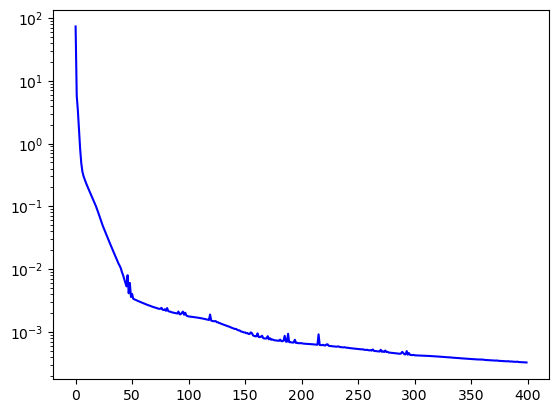

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_hist, 'b')
ax.set_yscale('log')
plt.show()


In [14]:
# Testing trained model

# Number of test points
N_test = 256**2

# Absolute error
X_inner_test = qmc.LatinHypercube(d=2).random(256**2)
x_test = X_inner_test[:, 0:1]
y_test = X_inner_test[:, 1:2]
z_test = z_val(x_test, y_test)
sign_test = sign_x(x_test, y_test)
h_test = h_val(x_test, y_test)
g_test = g_val(x_test, y_test)
u_exact = exact_u(x_test, y_test, sign_test)
X_inner_test = np.hstack((X_inner_test, z_test))
X_inner_test_torch = torch.tensor(X_inner_test).double().to(device).requires_grad_(True)

with torch.no_grad():
    p_pred_torch = model_p(X_inner_test_torch)
    p_pred = h_test * p_pred_torch.detach().cpu().numpy()
    u_pred = -(1.0/alpha) * p_pred

error = np.absolute(u_pred - u_exact)

error_u = np.linalg.norm(error,2)/np.sqrt(N_test)
print('Error u (absolute 2-norm): %e' % (error_u))

# Relative error

def eu_minus_polar(r, theta):
    return r * (5.0 * (1.0 / alpha) * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[0])**2

def eu_plus_polar(r, theta):
    return r * (5.0 * (1.0 / alpha) * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[1])**2

def eu_plus_cart(x, y):
    return (5.0 * (1.0 / alpha) * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / beta[1])**2

norm_eu_minus_inner_squared = integrate.dblquad(eu_minus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
norm_eu_plus_whole_squared = integrate.dblquad(eu_plus_cart, -1.0, 1.0, -1.0, 1.0)
norm_eu_plus_inner_squared = integrate.dblquad(eu_plus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
norm_eu_plus_outer_squared = norm_eu_plus_whole_squared[0] - norm_eu_plus_inner_squared[0]
norm_eu = np.sqrt((norm_eu_minus_inner_squared[0] + norm_eu_plus_outer_squared) / 4.0) # Normalized by area

error_rel_u = error_u / norm_eu
print('Error u (relative 2-norm): %e' % (error_rel_u))


Error u (absolute 2-norm): 5.118835e-05
Error u (relative 2-norm): 1.675656e-04


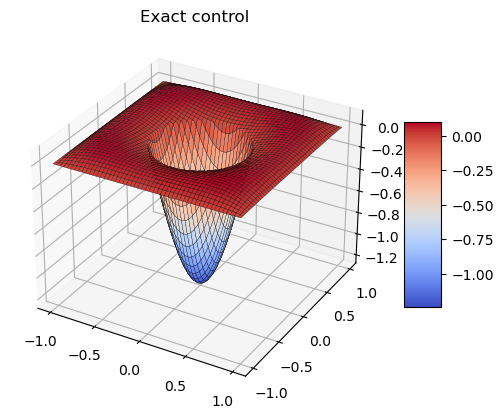

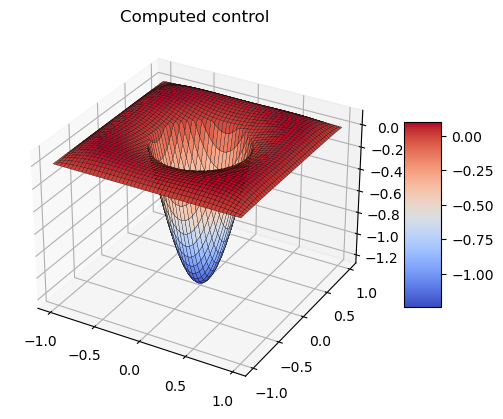

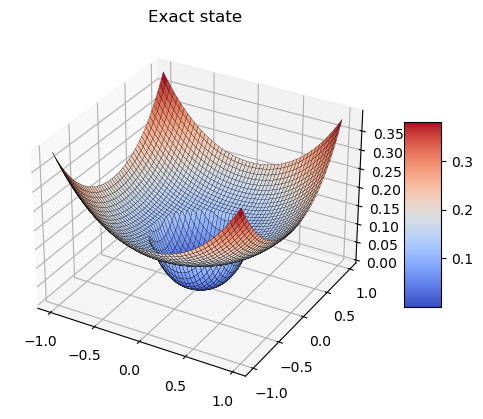

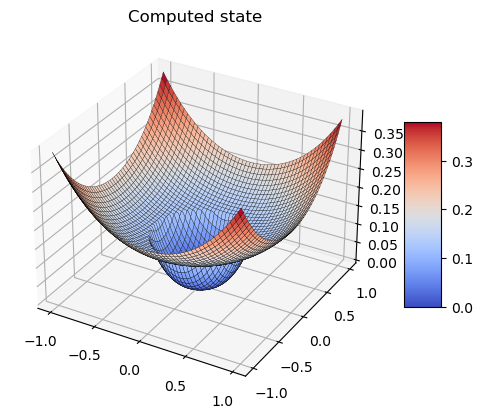

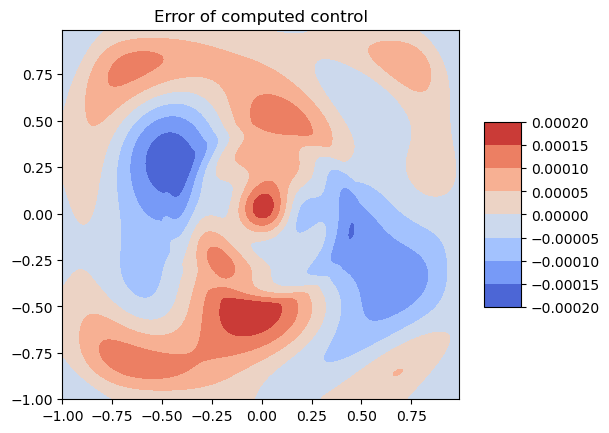

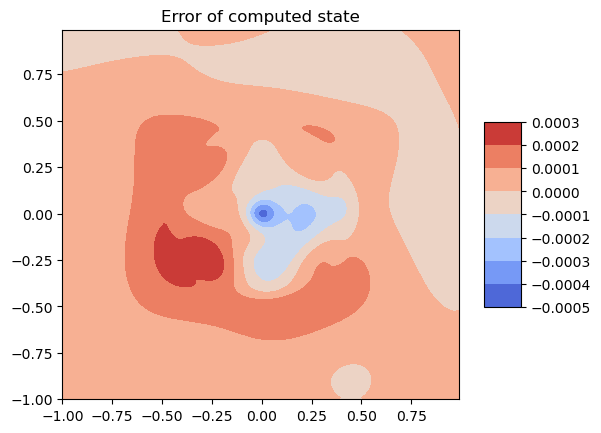

In [15]:
# Plot the solution

xlist = ylist = np.arange(-1, 1, 0.01)
x_mesh, y_mesh = np.meshgrid(xlist, ylist)

z_plot = 0.0 * x_mesh + 1.0
sign_plot = 0.0 * x_mesh + 1.0
for i in range(len(z_plot)):
    for j in range(len(z_plot[i])):
        dist = np.sqrt(x_mesh[i, j]**2 + y_mesh[i, j]**2)
        if dist < r_0:
            z_plot[i, j] = 4.0 * (dist**2)
            sign_plot[i, j] = -1.0

eu = exact_u(x_mesh, y_mesh, sign_plot)
ev = exact_v(x_mesh, y_mesh, sign_plot)
h_plot = h_val(x_mesh, y_mesh)
g_plot = g_val(x_mesh, y_mesh)

# Reshaping data for neural network processing
x_mesh_r = x_mesh.reshape(40000)
y_mesh_r = y_mesh.reshape(40000)
z_plot_r = z_plot.reshape(40000)
h_plot_r = h_plot.reshape(40000, 1)
g_plot_r = g_plot.reshape(40000, 1)
data_plot = np.stack((x_mesh_r, y_mesh_r, z_plot_r), axis=-1)
data_plot_torch = torch.tensor(data_plot).double().to(device)
pp = model_p(data_plot_torch).detach().cpu().numpy()
pv = model_v(data_plot_torch).detach().cpu().numpy()
pp = h_plot_r * pp
pv = g_plot_r + h_plot_r * pv
pu = -(1.0/alpha) * pp
pu = pu.reshape(200, 200)
pv = pv.reshape(200, 200)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_eu = ax.plot_surface(x_mesh, y_mesh, eu, cmap=cm.coolwarm, linewidth=0.2)
surf_eu.set_edgecolors("black")
ax.title.set_text('Exact control')
fig.colorbar(surf_eu, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pu = ax.plot_surface(x_mesh, y_mesh, pu, cmap=cm.coolwarm, linewidth=0.2)
surf_pu.set_edgecolors("black")
ax.title.set_text('Computed control')
fig.colorbar(surf_pu, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_ev = ax.plot_surface(x_mesh, y_mesh, ev, cmap=cm.coolwarm, linewidth=0.2)
surf_ev.set_edgecolors("black")
ax.title.set_text('Exact state')
fig.colorbar(surf_ev, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pv = ax.plot_surface(x_mesh, y_mesh, pv, cmap=cm.coolwarm, linewidth=0.2)
surf_pv.set_edgecolors("black")
ax.title.set_text('Computed state')
fig.colorbar(surf_pv, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots()
surf_u_diff = ax.contourf(x_mesh, y_mesh, pu - eu, cmap=cm.coolwarm)
fig.colorbar(surf_u_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed control')
plt.show()

fig, ax = plt.subplots()
surf_v_diff = ax.contourf(x_mesh, y_mesh, pv - ev, cmap=cm.coolwarm)
fig.colorbar(surf_v_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed state')
plt.show()


In [16]:
# Save model, loss log and data set

model_filename = "results/ex1_alg2_trained_model.pt"
torch.save({"model_v_state_dict": model_v.state_dict(),
            "model_p_state_dict": model_p.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()}, model_filename)

csvfile = open("results/ex1_alg_2_loss_hist.csv", 'w')
writer = csv.writer(csvfile)
writer.writerow(loss_hist)
csvfile.close()

data_filename_train = "results/ex1_alg2_data_train.npz"
np.savez(data_filename_train, X_inner=X_inner.cpu().detach().numpy(), X_ij=X_ij.cpu().detach().numpy())

data_filename_test = "results/ex1_alg2_data_test.npz"
np.savez(data_filename_test, X_inner_test=X_inner_test)


In [17]:
# Load trained model

# model_v = PINN(3, 100, 1).to(device)
# model_p = PINN(3, 100, 1).to(device)
# optimizer = torch.optim.Adam(
#     list(model_v.parameters()) + list(model_p.parameters()),
#     lr=0.001)

# model_filename = "results/ex1_alg2_trained_model.pt"
# checkpoint = torch.load(model_filename)
# model_v.load_state_dict(checkpoint['model_v_state_dict'])
# model_p.load_state_dict(checkpoint['model_p_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
